In [1]:
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM, Input, Masking
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Model, load_model
from keras.callbacks import Callback, CSVLogger
import keras.callbacks as callbacks
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.ticker as ticker
import os
import shutil
from snapshot import SnapshotCallbackBuilder

import random
from sklearn.model_selection import train_test_split


Using TensorFlow backend.
/home/scicchitano/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/scicchitano/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/scicchitano/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/scicchitano/.local/lib/python3.6/site-packag

In [20]:
fine_training_1 =250  # 12.04.2016   
inizio_training_2 = 345 # 21.7.2016  
fine_training_2 =1200 # --> 18.11.2018 
fine_test_2 = 1300 # 26.2.2019

window_size_ = 50
window_shift_ = 1


def create_sequences(matrix, window_size, window_shift):
    n_seq = matrix.shape[0]
    n_feats = matrix.shape[1]

    start_indexes = range(0, n_seq - window_size + 1, window_shift)
    end_indexes = range(window_size, n_seq + 1, window_shift)

    tensor = [matrix[start_indexes[i]: end_indexes[i]] for i in range(len(start_indexes))]

    diff = n_seq - end_indexes[-1]

    if diff > 0:
        new_rows = np.zeros((window_size, n_feats))
        new_rows[0: n_seq - start_indexes[-1] - window_shift, :] = matrix[start_indexes[-1] + window_shift:, :]
        tensor.append(new_rows)

    return np.array(tensor)

def createSets():
    frame = pd.read_csv('Preprocessed_Dataset.csv', low_memory=False)
    timestamp_list = frame['timestamp']
    
    
    dataframe = frame[['block_size_average','provided_gas_average','block_difficulty_average',
                                    'transactions_average_per_block',
                                    'gas_used_sum','transactions_number']]
    


    dataframe.columns = [''] * len(dataframe.columns)
    training_1 = dataframe[:fine_training_1]
    test_1 = dataframe[fine_training_1:inizio_training_2]
    training_2 = dataframe[inizio_training_2:fine_training_2]
    test_2 = dataframe[fine_training_2:fine_test_2]

    training_1 = np.array(training_1, dtype='float64')
    test_1 = np.array(test_1, dtype='float64')
    training_2 = np.array(training_2, dtype='float64')
    test_2 = np.array(test_2, dtype='float64')

    return training_1, test_1, training_2, test_2, dataframe, timestamp_list

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('plot/loss/m_'+ str(M) + '_training_set' + '.pdf')
    plt.show()

In [21]:
training_1, test_1, training_2, test_2, dataframe, timestamp_list = createSets()

training_1 = create_sequences(training_1,window_size_,window_shift_)
test_1 = create_sequences(test_1,window_size_,window_shift_)
training_2 = create_sequences(training_2,window_size_,window_shift_)
test_2 = create_sequences(test_2,window_size_,window_shift_)

training_set = np.concatenate((training_1,training_2), axis=0)

In [22]:
seq_len = training_set.shape[1]
n_features = training_set.shape[2]
cells = 32

input_layer = Input((seq_len, n_features))

x = Masking()(input_layer)
x = LSTM(cells, activation='tanh')(x)
x = RepeatVector(seq_len)(x)
x = LSTM(cells, activation='tanh', return_sequences=True)(x)
output_layer = TimeDistributed(Dense(n_features))(x)

model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 50, 6)             0         
_________________________________________________________________
masking_4 (Masking)          (None, 50, 6)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                4992      
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 50, 32)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 32)            8320      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 50, 6)             198       
Total params: 13,510
Trainable params: 13,510
Non-trainable params: 0
_______________________________________________________

Train on 805 samples, validate on 202 samples
Epoch 1/200
 - 2s - loss: 0.3174 - val_loss: 0.7172
Epoch 2/200
 - 1s - loss: 0.3015 - val_loss: 0.6814
Epoch 3/200
 - 1s - loss: 0.2958 - val_loss: 0.6920
Epoch 4/200
 - 1s - loss: 0.2930 - val_loss: 0.6918
Epoch 5/200
 - 1s - loss: 0.2960 - val_loss: 0.7019
Epoch 6/200
 - 1s - loss: 0.2966 - val_loss: 0.7065
Epoch 7/200
 - 1s - loss: 0.2916 - val_loss: 0.6928
Epoch 8/200
 - 1s - loss: 0.2977 - val_loss: 0.6959
Epoch 9/200
 - 1s - loss: 0.2913 - val_loss: 0.6981
Epoch 10/200
 - 1s - loss: 0.2843 - val_loss: 0.6990
Epoch 11/200
 - 1s - loss: 0.2797 - val_loss: 0.7069
Epoch 12/200
 - 1s - loss: 0.2800 - val_loss: 0.6888
Epoch 13/200
 - 1s - loss: 0.2803 - val_loss: 0.6992
Epoch 14/200
 - 1s - loss: 0.2716 - val_loss: 0.7115
Epoch 15/200
 - 1s - loss: 0.2668 - val_loss: 0.6978
Epoch 16/200
 - 1s - loss: 0.2606 - val_loss: 0.6948
Epoch 17/200
 - 1s - loss: 0.2686 - val_loss: 0.6934
Epoch 18/200
 - 1s - loss: 0.2636 - val_loss: 0.7072
Epoch 19/

Epoch 154/200
 - 1s - loss: 0.1753 - val_loss: 0.7187
Epoch 155/200
 - 1s - loss: 0.1719 - val_loss: 0.7184
Epoch 156/200
 - 1s - loss: 0.1708 - val_loss: 0.7183
Epoch 157/200
 - 1s - loss: 0.1701 - val_loss: 0.7185
Epoch 158/200
 - 1s - loss: 0.1699 - val_loss: 0.7186
Epoch 159/200
 - 1s - loss: 0.1698 - val_loss: 0.7187
Epoch 160/200
 - 1s - loss: 0.1697 - val_loss: 0.7186
Epoch 161/200
 - 1s - loss: 0.2207 - val_loss: 0.6994
Epoch 162/200
 - 1s - loss: 0.2306 - val_loss: 0.7099
Epoch 163/200
 - 1s - loss: 0.2078 - val_loss: 0.7140
Epoch 164/200
 - 1s - loss: 0.2136 - val_loss: 0.7177
Epoch 165/200
 - 1s - loss: 0.2061 - val_loss: 0.7095
Epoch 166/200
 - 1s - loss: 0.2138 - val_loss: 0.7082
Epoch 167/200
 - 1s - loss: 0.2059 - val_loss: 0.6975
Epoch 168/200
 - 1s - loss: 0.2032 - val_loss: 0.7044
Epoch 169/200
 - 1s - loss: 0.2383 - val_loss: 0.7054
Epoch 170/200
 - 1s - loss: 0.2419 - val_loss: 0.7016
Epoch 171/200
 - 1s - loss: 0.2191 - val_loss: 0.7177
Epoch 172/200
 - 1s - loss: 

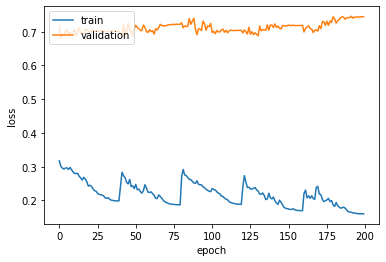

In [23]:
snapshot = SnapshotCallbackBuilder(T, M, alpha_zero)
history_ = model.fit(training_set, training_set, epochs=T, batch_size=50,
                     verbose=2, validation_split=0.2, callbacks= snapshot.get_callbacks())
plot_loss(history_)

In [24]:
def sliding_average(predictions, window_shift, timestamps):
    sliding_avg = defaultdict(lambda: 0)
    count = defaultdict(lambda: 0)
    i = 0
    for index, line in enumerate(predictions):
        for pred in line:
            q = timestamps[i]
            count[q] += 1
            sliding_avg[timestamps[i]] += pred
            i += 1
        i = i - len(line) + window_shift
    for timestamp in sliding_avg.keys():
        if sliding_avg[timestamp] > 0:
            sliding_avg[timestamp] = sliding_avg[timestamp] / count[timestamp]
    return sliding_avg

In [25]:
weights_path = os.listdir('weights')
scores = []
timestamp_test = timestamp_list[fine_training_2: fine_test_2].tolist() # --> 2019 Attack
#timestamp_test = timestamp_list[fine_training_1: inizio_training_2].tolist() # --> DAO attack

for model_weight in weights_path:
    model.load_weights('weights/'+ model_weight)
    prediction_test = model.predict(test_2)
    outlierness_ = sliding_average(
    np.sum(np.power(np.absolute(test_2 - prediction_test), 2), axis=2), window_shift_, timestamp_test)
    scores.append(list(outlierness_.values()))               
        
stack = np.stack(scores).transpose()
median_score = np.median(stack, axis = 1)

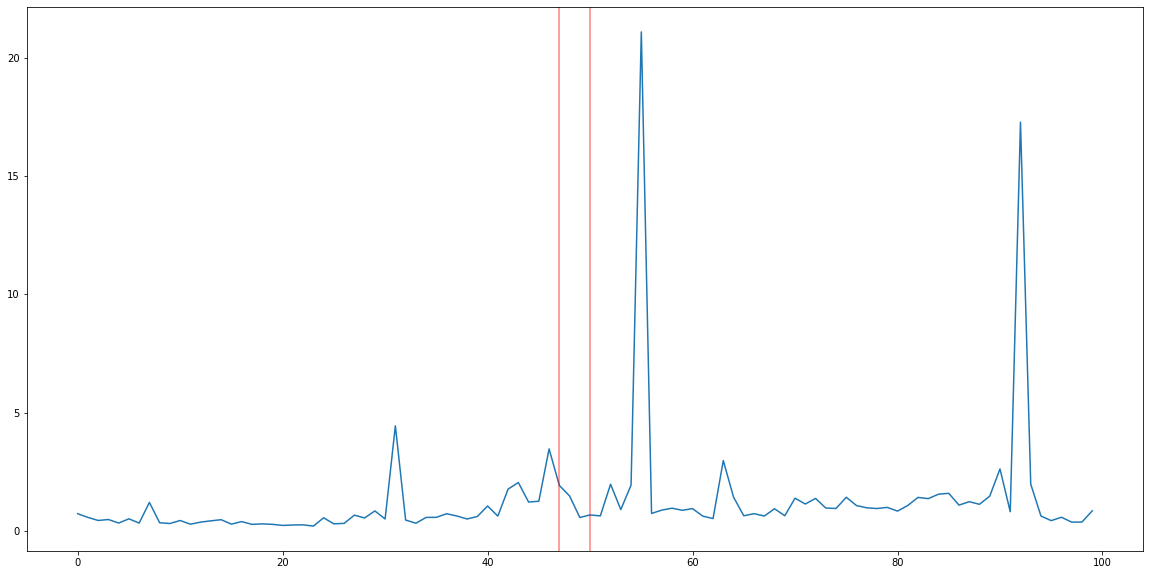

In [26]:
fig, ax = plt.subplots(figsize=(20,10))

plt.plot(range(100),median_score)
#ax.axvline(x=66, color='red', alpha=0.5) 
ax.axvline(x=47, color='red', alpha=0.5)
ax.axvline(x=50, color='red', alpha=0.5)
plt.savefig('plot/score/attack_2019_m_'+ str(M) + '_training_set' + '.pdf')
plt.show()


In [22]:
T = 200 # epoch number
M = 10 # snapshot number
alpha_zero = 0.01 # initially learning rate 
anomaly_perc = 0.03

days = 1440
features = 128

shutil.rmtree('weights_synthetic/')

def create_sequences(matrix, window_size, window_shift):
    n_seq = matrix.shape[0]
    n_feats = matrix.shape[1]

    start_indexes = range(0, n_seq - window_size + 1, window_shift)
    end_indexes = range(window_size, n_seq + 1, window_shift)

    tensor = [matrix[start_indexes[i]: end_indexes[i]] for i in range(len(start_indexes))]

    diff = n_seq - end_indexes[-1]

    if diff > 0:
        new_rows = np.zeros((window_size, n_feats))
        new_rows[0: n_seq - start_indexes[-1] - window_shift, :] = matrix[start_indexes[-1] + window_shift:, :]
        tensor.append(new_rows)

    return np.array(tensor)


def sliding_average(predictions, window_shift, timestamps):
    sliding_avg = defaultdict(lambda: 0)
    count = defaultdict(lambda: 0)
    i = 0
    for index, line in enumerate(predictions):
        for pred in line:
            q = timestamps[i]
            count[q] += 1
            sliding_avg[timestamps[i]] += pred
            i += 1
        i = i - len(line) + window_shift
    for timestamp in sliding_avg.keys():
        if sliding_avg[timestamp] > 0:
            sliding_avg[timestamp] = sliding_avg[timestamp] / count[timestamp]
    return sliding_avg



def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('plot/loss/anomaly_perc_' + str(anomaly_perc) + '_m_'+ str(M) + '_nFeat_' + str(features)+ '.pdf')
    plt.show()
    

def create_synthetic_data(days, features, anomaly_perc=0.01):
    data = np.zeros((days, features + 1))
    n_anomalies = int(anomaly_perc * days)

    for i in range(days):
        data[i, :-1] = np.random.normal(0, 1, features)

        if i < n_anomalies:
            sgn = 1 if random.random() < 0.5 else -1
            data[i, np.random.randint(features)] = sgn * (np.random.random() * 70 + 30)
            data[i, -1] = 1
    np.random.shuffle(data)
    return data[:, :-1], data[:, -1]


concat, classes = create_synthetic_data(days, features)
x_train, x_test, y_train, y_test = train_test_split(concat, classes, test_size=0.2)
x_training = create_sequences(x_train, window_size_, window_shift_)
x_testing = create_sequences(x_test, window_size_, window_shift_)


In [23]:
seq_len = x_training.shape[1]
n_features = x_training.shape[2]
cells = 32

input_layer = Input((seq_len, n_features))

x = Masking()(input_layer)
x = LSTM(cells, activation='tanh')(x)
x = RepeatVector(seq_len)(x)
x = LSTM(cells, activation='tanh', return_sequences=True)(x)
output_layer = TimeDistributed(Dense(n_features))(x)

model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 50, 128)           0         
_________________________________________________________________
masking_6 (Masking)          (None, 50, 128)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                20608     
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 50, 32)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50, 32)            8320      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 50, 128)           4224      
Total params: 33,152
Trainable params: 33,152
Non-trainable params: 0
_______________________________________________________

Train on 882 samples, validate on 221 samples
Epoch 1/200
 - 3s - loss: 1.4177 - val_loss: 1.0550
Epoch 2/200
 - 1s - loss: 1.4069 - val_loss: 1.0552
Epoch 3/200
 - 1s - loss: 1.4006 - val_loss: 1.0555
Epoch 4/200
 - 1s - loss: 1.3971 - val_loss: 1.0563
Epoch 5/200
 - 1s - loss: 1.3959 - val_loss: 1.0563
Epoch 6/200
 - 1s - loss: 1.3924 - val_loss: 1.0606
Epoch 7/200
 - 1s - loss: 1.3907 - val_loss: 1.0610
Epoch 8/200
 - 1s - loss: 1.3881 - val_loss: 1.0612
Epoch 9/200
 - 1s - loss: 1.3842 - val_loss: 1.0612
Epoch 10/200
 - 1s - loss: 1.3805 - val_loss: 1.0621
Epoch 11/200
 - 1s - loss: 1.3774 - val_loss: 1.0644
Epoch 12/200
 - 1s - loss: 1.3755 - val_loss: 1.0656
Epoch 13/200
 - 1s - loss: 1.3700 - val_loss: 1.0665
Epoch 14/200
 - 1s - loss: 1.3655 - val_loss: 1.0684
Epoch 15/200
 - 1s - loss: 1.3609 - val_loss: 1.0697
Epoch 16/200
 - 1s - loss: 1.3575 - val_loss: 1.0725
Epoch 17/200
 - 1s - loss: 1.3550 - val_loss: 1.0731
Epoch 18/200
 - 1s - loss: 1.3521 - val_loss: 1.0747
Epoch 19/

Epoch 154/200
 - 1s - loss: 1.3218 - val_loss: 1.1049
Epoch 155/200
 - 1s - loss: 1.3186 - val_loss: 1.1102
Epoch 156/200
 - 1s - loss: 1.3122 - val_loss: 1.1110
Epoch 157/200
 - 1s - loss: 1.3091 - val_loss: 1.1103
Epoch 158/200
 - 1s - loss: 1.3055 - val_loss: 1.1118
Epoch 159/200
 - 1s - loss: 1.3021 - val_loss: 1.1130
Epoch 160/200
 - 1s - loss: 1.3007 - val_loss: 1.1132
Epoch 161/200
 - 1s - loss: 1.3393 - val_loss: 1.1173
Epoch 162/200
 - 1s - loss: 1.3619 - val_loss: 1.0968
Epoch 163/200
 - 1s - loss: 1.3655 - val_loss: 1.0887
Epoch 164/200
 - 1s - loss: 1.3592 - val_loss: 1.1097
Epoch 165/200
 - 1s - loss: 1.3575 - val_loss: 1.0950
Epoch 166/200
 - 1s - loss: 1.3568 - val_loss: 1.1051
Epoch 167/200
 - 1s - loss: 1.3492 - val_loss: 1.1005
Epoch 168/200
 - 1s - loss: 1.3449 - val_loss: 1.1032
Epoch 169/200
 - 1s - loss: 1.3466 - val_loss: 1.1071
Epoch 170/200
 - 1s - loss: 1.3438 - val_loss: 1.1087
Epoch 171/200
 - 1s - loss: 1.3376 - val_loss: 1.1105
Epoch 172/200
 - 1s - loss: 

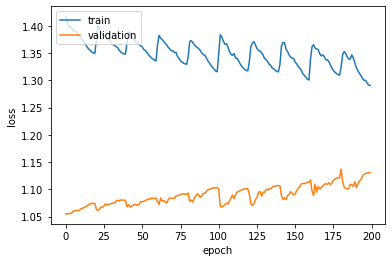

In [24]:
snapshot = SnapshotCallbackBuilder(T, M, alpha_zero)

history_ = model.fit(x_training, x_training, epochs=T, batch_size=50,
                     verbose=2, validation_split=0.2, callbacks=snapshot.get_callbacks())

plot_loss(history_)

N° outliers: 3.0


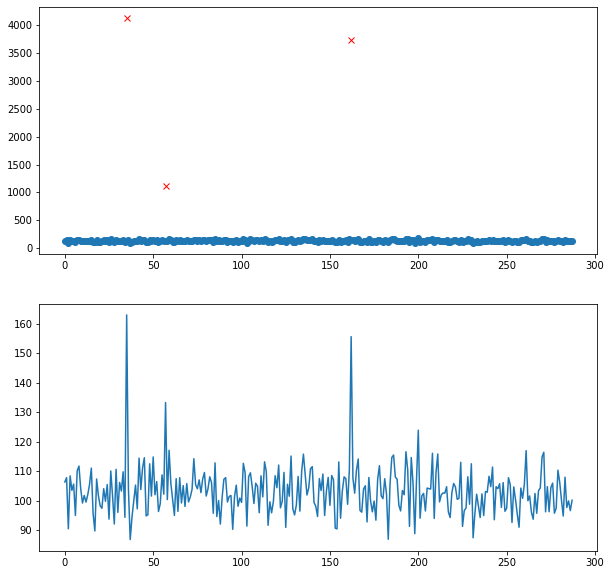

In [25]:
weights_path = os.listdir('weights_synthetic')
scores = []
timestamp_test = np.array(list(range(len(x_test))))

for model_weight in weights_path:
    model.load_weights('weights_synthetic/' + model_weight)
    prediction_test = model.predict(x_testing)

    outlierness_ = sliding_average(
        np.sum(np.power(np.absolute(x_testing - prediction_test), 2), axis=2), window_shift_, timestamp_test)
    scores.append(list(outlierness_.values()))

stack = np.stack(scores).transpose()
median_score = np.median(stack, axis=1)

print('N° outliers:', sum(y_test))

weight = 10
height = 10
fig, axes = plt.subplots(2, 1, figsize=(weight, height))
axes[0].plot(timestamp_test[y_test == 0], median_score[y_test == 0], 'o')
axes[0].plot(timestamp_test[y_test == 1], median_score[y_test == 1], 'xr')

axes[1].plot(np.sum(np.abs(x_test), axis=1))

plt.savefig('plot/score/anomaly_perc_' + str(anomaly_perc) + '_m_'+ str(M) + '_nFeat_' + str(features) + '.pdf')


plt.show()